# Import Library

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout 
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from collections import Counter

# Data Preprocessing

In [2]:
data_dir = 'Data/data/The IQ-OTHNCCD lung cancer dataset/'

categories = ['bengin', 'malignant', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (32, 32))
    img = img / 255.0  # Chuẩn hóa pixel trong khoảng [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)

# Kiểm tra cân bằng dữ liệu
print('Data length:', len(data))
print('labels counts:', Counter(labels))

# normalize
X = np.array(data).reshape(-1, 32, 32, 1)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


# Split Data

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=10)

print('Train length:', len(X_train), X_train.shape)
print('Test length:', len(X_valid), X_valid.shape)

Train length: 767 (767, 32, 32, 1)
Test length: 330 (330, 32, 32, 1)


# Data Augmentation

In [4]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=8, shuffle=True)
validation_generator = val_datagen.flow(X_valid, y_valid, batch_size=8, shuffle=True)


# Build Lenet-5 Model

In [5]:
def Lenet(input_shape=(32,32,1)):
        # Input
        inp = Input(input_shape)
        # Conv1
        x = Conv2D(6, 5, activation='tanh')(inp)
        # Average Pooling 1
        x = AveragePooling2D(2, 2)(x)
        # Conv2
        x = Conv2D(16, 5, activation='tanh')(x)
        # Average Pooling 2
        x = AveragePooling2D(2, 2)(x)
        # Conv3
        x = Conv2D(120, 5, activation='tanh')(x)
        x = Flatten()(x)
        # Fully connected 
        x = Dense(84, activation='tanh')(x)
        # Output
        x = Dense(3, activation='softmax')(x)

        model = Model(inputs= inp, outputs=x)
        return model

model = Lenet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120 

In [6]:
# Create an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 3 consecutive epochs.
callback = EarlyStopping(monitor='val_loss', patience=3)

# Compile model

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Traning model

In [8]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])

Epoch 1/20
96/96 [==============================] - 1s 7ms/step - loss: 0.8838 - accuracy: 0.6128 - val_loss: 0.7740 - val_accuracy: 0.6576
Epoch 2/20
96/96 [==============================] - 1s 7ms/step - loss: 0.6928 - accuracy: 0.7249 - val_loss: 0.6310 - val_accuracy: 0.7121
Epoch 3/20
96/96 [==============================] - 1s 6ms/step - loss: 0.5874 - accuracy: 0.7510 - val_loss: 0.5705 - val_accuracy: 0.7545
Epoch 4/20
96/96 [==============================] - 1s 6ms/step - loss: 0.4984 - accuracy: 0.7901 - val_loss: 0.4595 - val_accuracy: 0.8030
Epoch 5/20
96/96 [==============================] - 1s 5ms/step - loss: 0.4566 - accuracy: 0.8214 - val_loss: 0.3879 - val_accuracy: 0.8394
Epoch 6/20
96/96 [==============================] - 1s 6ms/step - loss: 0.4100 - accuracy: 0.8305 - val_loss: 0.5011 - val_accuracy: 0.8061
Epoch 7/20
96/96 [==============================] - 1s 5ms/step - loss: 0.4012 - accuracy: 0.8383 - val_loss: 0.4108 - val_accuracy: 0.8152
Epoch 8/20
96/96 [==

# Model Evaluation

In [9]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

11/11 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.86      0.64      0.74        39
           1       0.98      0.89      0.93       180
           2       0.78      0.96      0.86       111

    accuracy                           0.88       330
   macro avg       0.87      0.83      0.84       330
weighted avg       0.90      0.88      0.88       330

[[ 25   3  11]
 [  1 160  19]
 [  3   1 107]]


# Graph

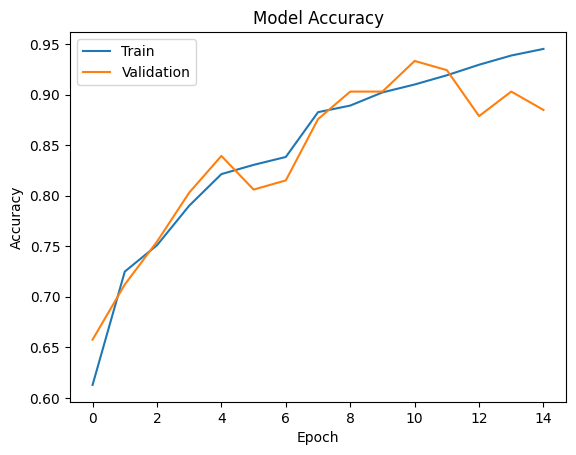

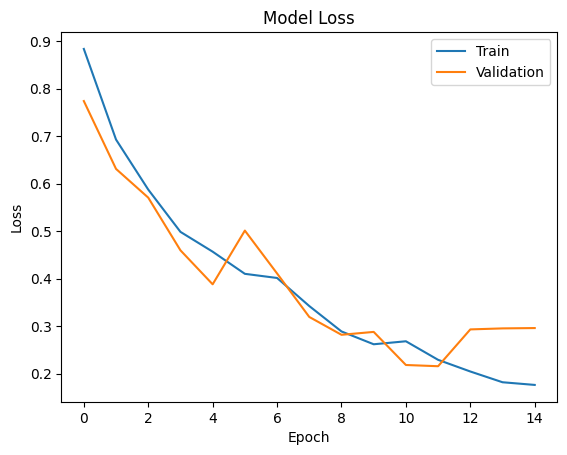

In [10]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()